In [1]:
# Definición y carga de las librerias

# import sklearn
from scipy.stats import mode
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_similarity_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_row', 1000)                         # set jupyter's max row display
pd.set_option('display.max_columns', 50)                       # set jupyter's max column width to 50
from random import sample
from sklearn.preprocessing import LabelEncoder

In [2]:
# Declaración de funciones

# def data_description_ltype(dataset, columnas=['']):
def data_description_ltype(dataset): 
    ds=dataset.dtypes
    ds=pd.DataFrame(ds)
    ds=ds.reset_index()
    ds.columns=['variables','tipos']
#     if columnas != ['']:
#         ds.columns=columnas
    return(ds)

def grafica_ver(data,columna='', titulo='Gráfica',yetiqueta=''):
    if columna == '':
        return(print('ingrese parametros'))
    ax = data[columna].value_counts().plot(kind='bar', figsize=(7,7), color="coral", fontsize=13);
    ax.set_alpha(0.2)
    ax.set_title(titulo, fontsize=12)
    ax.set_ylabel(yetiqueta, fontsize=12);
    ax.set_yticks([0, len(data)])
    totals = []
    for i in ax.patches:
        totals.append(i.get_height())
    total = sum(totals)
    for i in ax.patches:
        ax.text(i.get_x()+.12, i.get_height()-3, \
                str(i.get_height())+'\n('+str(round((i.get_height()/len(data))*100, 2))+'%)', fontsize=12,
                    color='dimgrey')

def grafica_hor(data,columna='', titulo='Gráfica',xetiqueta='x'):
    if columna == '':
        return(print('ingrese parametros'))
    
    ax =data[columna].value_counts().plot(kind='barh', figsize=(7,7), color="teal", fontsize=13);
    ax.set_alpha(0.2)
    ax.set_title(titulo, fontsize=12)
    ax.set_xlabel(xetiqueta, fontsize=12);
    ax.set_xticks([0, len(data)])
    totals = []                                          # create a list to collect the plt.patches data
    for i in ax.patches:                                 # find the values and append to list
        totals.append(i.get_width())
    total = sum(totals)                                  # set individual bar lables using above list
    for i in ax.patches:                                 
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(i.get_width())+' ('+str(round((i.get_width()/len(data))*100, 2))+'%)', fontsize=12, color='dimgrey')
    return(ax.invert_yaxis())                            # invert for largest on top 

def grafica_nul(data):
    df_limpiar=data.copy()
    df_limpiar= nulos(df_limpiar,'unknown','Nulos')
    df_limpiar= nulos(df_limpiar,999,'Nulos')
    df_limpiar=pd.DataFrame(df_limpiar.isnull().sum(), columns=['nulos'])
    df_limpiar = df_limpiar[df_limpiar.nulos != 0]
    df_limpiar=df_limpiar.sort_values('nulos', ascending=False)
    ax =df_limpiar['nulos'].plot(kind='barh', figsize=(7,7), color="salmon", fontsize=13);
    ax.set_alpha(0.2)
    ax.set_title('Datos Nulos', fontsize=12)
    ax.set_xlabel('Cantidad', fontsize=12);
    ax.set_xticks([0, len(data)])
    totals = []                                          
    for i in ax.patches:                                 
        totals.append(i.get_width())
    total = sum(totals)                                 
    for i in ax.patches:                                 
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(i.get_width())+' ('+str(round((i.get_width()/len(data))*100, 2))+'%)', fontsize=12, color='red')
    return(ax.invert_yaxis())
        
        
# Función para buscar valores y remplazar por otros, se hace para cambiar a nulos valores como los uknonw
def nulos(dataset, valini="",valfin=""):
    new=dataset.copy()
    for n in range(len(dataset.columns)):
#         dataset[dataset.columns[n]] = enc.fit_transform(dataset[dataset.columns[n]])
        if valfin == "Nulos":
            new[dataset.columns[n]]=dataset[dataset.columns[n]].replace([valini],np.NaN)
        else:
            new[dataset.columns[n]]=dataset[dataset.columns[n]].replace([valini],valfin)
    return(new)

def get_labels(dataset,objetive=''):
    target = dataset.loc[:,[objetive]].values
    labels_target=pd.DataFrame(dataset.loc[:,[objetive]].columns, columns=['target'])
    labels=pd.DataFrame(dataset.columns, columns=['full'])
    labels=labels[labels['full']!= objetive]
    labels_num=dataset._get_numeric_data().columns
    labels_text=pd.DataFrame(dataset.drop(labels_num[0],axis=1, inplace=False).columns[:-1], columns=['text'])
    labels_num=pd.DataFrame(labels_num, columns=['num'])
    l= pd.concat([labels,labels_text,labels_num, labels_target], axis=1)
    return(l)

def balanceo(data,objetivo='',tam_muestra=80):
    if objetivo=='':
        return(print('ingrese la variable objetivo para dividir el tamaño de la muestra'))
    df_y_yes=(data[data[objetivo]==1.0].reset_index()).drop('index', axis=1)
    df_y_no=(data[data[objetivo]==0.0].reset_index()).drop('index', axis=1)
    
    N=((data[objetivo][data[objetivo]==1].count()*tam_muestra)/100).astype(int)
    
    rows_y=list(range(0, len(df_y_yes)))
    rows_n=list(range(0, len(df_y_no)))
    
    ran_row_y=sample(rows_y,k=N)
    ran_row_n=sample(rows_n,k=N)
    
    finalDf_train=pd.concat([pd.DataFrame(df_y_yes, index=ran_row_y), pd.DataFrame(df_y_no, index=ran_row_n)])
    finalDf_train=finalDf_train.sort_index()
    
    finalDf_test=pd.concat([df_y_yes.drop(df_y_yes.index[ran_row_y], inplace=False), df_y_no.drop(df_y_no.index[ran_row_y], inplace=False)])
    finalDf_test=finalDf_test.sort_index().reset_index().drop('index', axis=1)
    return(finalDf_train, finalDf_test)

def limpiar_labels(label,columna):
    l=pd.DataFrame(label[columna])
    l=nulos(l,np.NaN,'unknwon')
    l=l[columna][l[columna] != 'unknwon']
    return(l)

# Factorizar
def factor(dataset,full=0):
    enc = LabelEncoder()
    labels=dataset._get_numeric_data().columns
    for n in range(len(dataset.columns)):
        if df.columns[n] not in labels:
            dataset[dataset.columns[n]] = enc.fit_transform(dataset[dataset.columns[n]])
        if full== 1:
            dataset[dataset.columns[n]] = enc.fit_transform(dataset[dataset.columns[n]])
    return(dataset)

#Estilo correlación
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "8pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# mapa de correlación
def correl(correlacion):
    cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
    return (correlacion.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Estilo tabla")\
        .set_precision(2)\
        .set_table_styles(magnify()))

def grafica_scores(modelo, x_test, y_test, y_pred):
#     print("Score:",lr.score(x_test_true,y_test_true))
#     print("accuracy_score:",accuracy_score(y_true = y_test_true, y_pred = y_test_pred_true))
#     print("Tasa de error:",1-accuracy_score(y_true = y_test, y_pred = y_pred))
#     print("jaccard_similarity_score",jaccard_similarity_score(y_true=y_test_true, y_pred=y_test_pred_true))
#     print(print("\n\nclassification_report\n---------------------\n",classification_report(y_true=y_test_true, y_pred=y_test_pred_true)))
    
    print("Score:",modelo.score(x_test,y_test))
    print("accuracy_score:",accuracy_score(y_true = y_test, y_pred = y_pred))
    print("Tasa de error:",1-accuracy_score(y_true = y_test, y_pred = y_pred))
    print("jaccard_similarity_score",jaccard_similarity_score(y_true=y_test, y_pred=y_pred))
    print(print("\n\nclassification_report\n---------------------\n",classification_report(y_true=y_test, y_pred=y_pred)))

def grafica_matriz_confusion(modelo):
#     modelo = confusion_matrix(y_test, y_pred)
    print('\n')
    ax= plt.subplot()
    sns.heatmap(modelo, annot=True, ax = ax,square=True, cmap="YlGnBu", annot_kws={"size":12}, fmt="d");
    ax.set_xlabel('Predicción' , fontsize='16');
    ax.set_ylabel('Verdaderos' , fontsize='16'); 
    ax.set_title('Matriz de confusión', fontsize='18'); 
    ax.xaxis.set_ticklabels(['no', 'yes'], fontsize='16'); 
    ax.yaxis.set_ticklabels(['no', 'yes'], fontsize='16');

In [3]:
# importación de los datos
df = pd.read_csv('DBM_Data/bank_af.csv', delimiter=";")
df=df.drop(['duration'], axis=1)
# df.dtypes

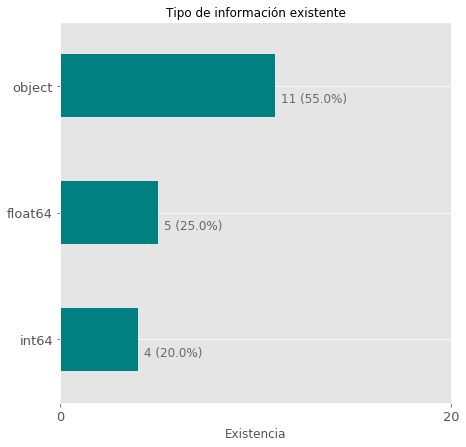

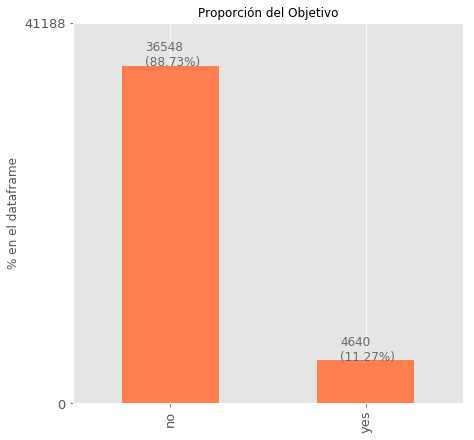

In [4]:
grafica_hor(data_description_ltype(df),'tipos', 'Tipo de información existente','Existencia')
# plt.subplots(1, 1)
# grafica_nul(df)
plt.subplots(1, 1)
grafica_ver(df,'y','Proporción del Objetivo', '% en el dataframe')

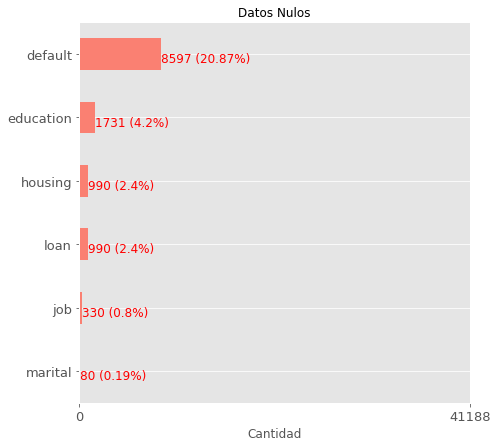

In [5]:
df=df.drop('pdays',axis=1)
grafica_nul(df)

In [6]:
# labels_name=get_labels(df,'y')
# # labels.full[labels['full']!=np.NaN]
# labels_name

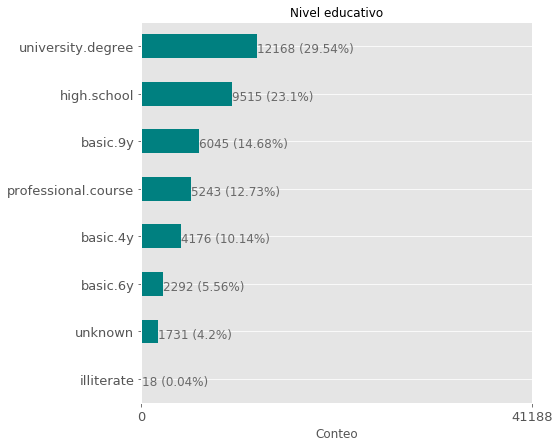

In [7]:
education=df.groupby('education').size()
# education.reset_index()
grafica_hor(df,'education','Nivel educativo','Conteo')

In [8]:
df.education=df['education'].replace(['unknown','illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree']
                                    ,['0','1','2','3','4','5','6','7'])
df.education=pd.to_numeric(df['education'])

In [9]:
target = factor(pd.DataFrame(df.loc[:,['y']].values, columns=['target']))
# target=pd.DataFrame(df.loc[:,['y']].values, columns=['target'])
labels_data=get_labels(df,'y')
labels_t=limpiar_labels(labels_data, 'text')
labels_n=limpiar_labels(labels_data, 'num')
df_dummy = pd.get_dummies(df[labels_t])
df_final=pd.concat([df[labels_n],df_dummy, target], axis=1)
labels_dummy=df_final.columns
df_final.describe()
# labels_data

,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,target
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,4.944037,2.567593,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,4.944037,2.567593,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,...,0.523842,0.824269,0.024036,0.151695,0.634748,0.365252,0.063902,0.149995,0.004419,0.174177,0.129115,0.013256,0.334296,0.099568,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335,0.112654
std,10.42125,1.909312,2.770014,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,1.909312,2.770014,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,...,0.499437,0.380596,0.153163,0.358729,0.481507,0.481507,0.244581,0.357071,0.066328,0.379266,0.335332,0.114372,0.471750,0.299427,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512,0.316173
min,17.00000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,4.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,4.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,38.00000,5.000000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,5.000000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,47.00000,7.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,7.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0000

In [10]:
correlations = df.corr()
correl(correlations)

,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1,-0.18,0.0046,0.024,-0.00037,0.00086,0.13,0.011,-0.018
education,-0.18,1,-0.0017,0.017,-0.039,-0.097,0.038,-0.03,-0.021
campaign,0.0046,-0.0017,1,-0.079,0.15,0.13,-0.014,0.14,0.14
previous,0.024,0.017,-0.079,1,-0.42,-0.2,-0.051,-0.45,-0.5
emp.var.rate,-0.00037,-0.039,0.15,-0.42,1,0.78,0.2,0.97,0.91
cons.price.idx,0.00086,-0.097,0.13,-0.2,0.78,1,0.059,0.69,0.52
cons.conf.idx,0.13,0.038,-0.014,-0.051,0.2,0.059,1,0.28,0.1
euribor3m,0.011,-0.03,0.14,-0.45,0.97,0.69,0.28,1,0.95
nr.employed,-0.018,-0.021,0.14,-0.5,0.91,0.52,0.1,0.95,1


In [11]:
scaler = MinMaxScaler()
datos = scaler.fit_transform(df_final)
datos=pd.DataFrame(datos, columns=[labels_dummy])
# labels_data=datos.columns
datos.head(10)

,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,target
0,0.481481,0.285714,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.285714,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.493827,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.246914,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.283951,0.428571,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.428571,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.481481,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.345679,0.571429,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.571429,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.518519,0.857143,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.857143,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.296296,0.000000,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.000000,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.086420,0.857143,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.857143,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.098765,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.714286,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


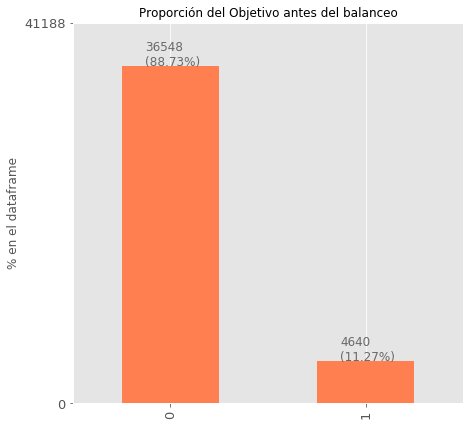

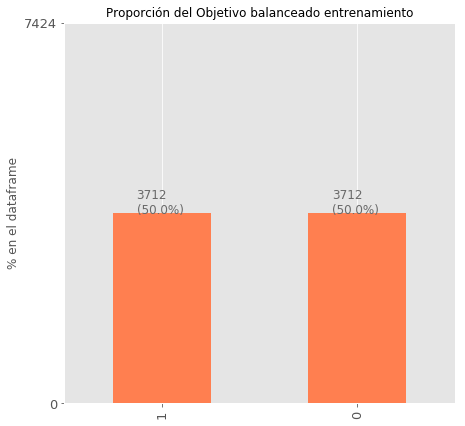

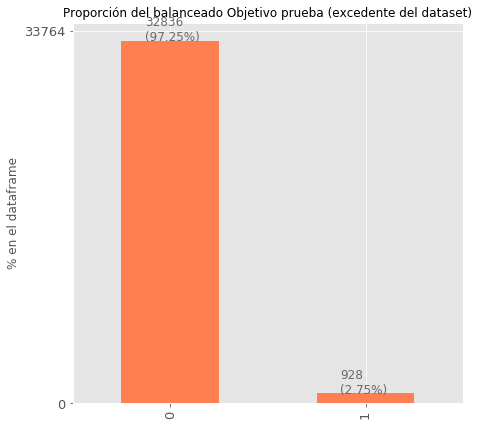

In [12]:
finalDf_train, finalDf_test=balanceo(df_final,objetivo='target',tam_muestra=80)
# print(finalDf_test.shape, finalDf_train.shape)
grafica_ver(df_final,'target','Proporción del Objetivo antes del balanceo', '% en el dataframe')
plt.subplots(1, 1)
grafica_ver(finalDf_train,'target','Proporción del Objetivo balanceado entrenamiento', '% en el dataframe')
plt.subplots(1, 1)
grafica_ver(finalDf_test,'target','Proporción del balanceado Objetivo prueba (excedente del dataset)'
            , '% en el dataframe')

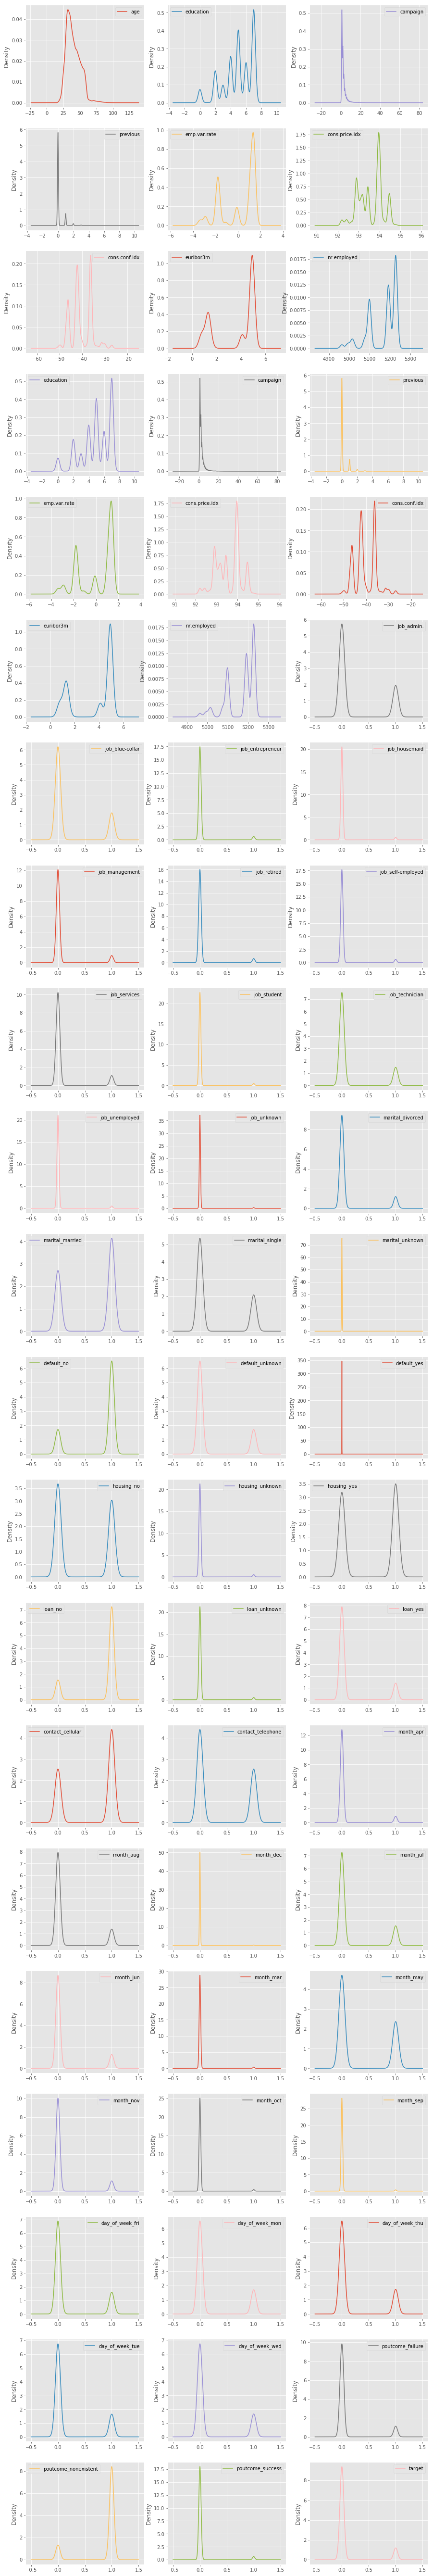

In [13]:
df_final.plot(kind='density', subplots=True, layout=(64,3), sharex=False, figsize=(15,300))
plt.show()

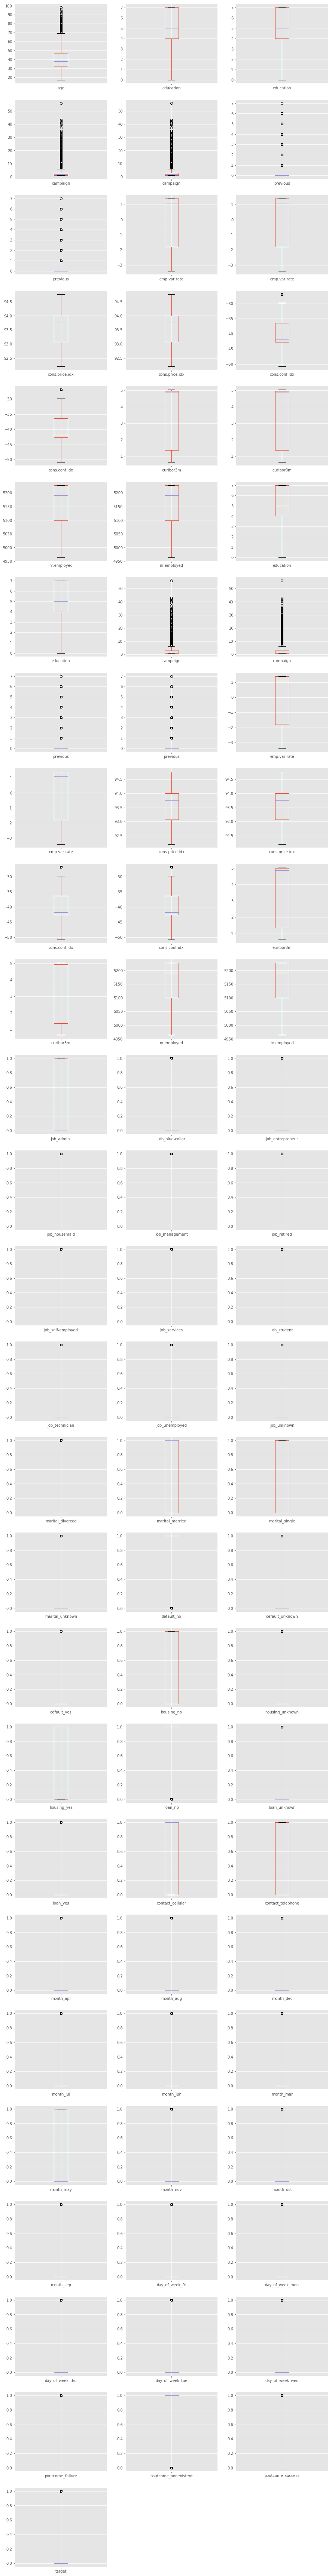

In [14]:
df_final[labels_dummy].plot(kind='box', subplots=True, layout=(64,3), sharex=False, sharey=False, figsize=(15,300))
plt.show()

In [15]:
# Matriz ce correlación
df_final.corr()
# correl(correlations)

,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,target
age,1.000000,-0.181930,0.004594,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,-0.181930,0.004594,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,-0.102584,-0.024191,0.031213,0.085403,0.062040,0.440772,-0.001356,-0.065731,...,-0.001414,0.007224,-0.001092,-0.007198,-0.007021,0.007021,0.014285,0.065309,0.046563,-0.043563,-0.009532,0.008390,-0.067523,0.030045,0.053008,0.040889,0.007148,0.019027,-0.021356,0.019137,-0.023671,-0.002537,-0.016376,0.035626,0.030399
education,-0.181930,1.000000,-0.001729,0.017439,-0.038992,-0.096554,0.038230,-0.030160,-0.020697,1.000000,-0.001729,0.017439,-0.038992,-0.096554,0.038230,-0.030160,-0.020697,0.297503,-0.443976,0.026201,-0.119471,0.154868,-0.106842,0.074657,-0.051706,...,0.021679,-0.009290,-0.007273,0.012962,0.108651,-0.108651,-0.002064,0.141659,0.005020,-0.046656,-0.036913,0.023077,-0.097915,0.067675,0.011774,0.012071,-0.007227,0.010377,0.009363,-0.011307,-0.001718,0.007019,-0.018360,0.023224,0.031800
campaign,0.004594,-0.001729,1.000000,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.001729,1.000000,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,0.011745,-0.001775,-0.002203,0.004226,-0.009135,-0.006847,0.006361,0.002383,...,-0.010800,-0.004831,-0.000396,0.005294,-0.077368,0.077368,-0.058519,0.015009,-0.009819,0.098385,0.070144,-0.015244,-0.032704,-0.079028,-0.049126,-0.033953,0.026641,0.014405,0.005141,-0.025125,-0.021088,-0.068890,0.087645,-0.050893,-0.066357
previous,0.024365,0.017439,-0.079141,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.017439,-0.079141,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.018888,-0.054845,-0.013239,-0.011569,0.006735,0.065113,-0.011231,-0.011885,...,0.020446,0.000504,0.003769,-0.002143,0.212848,-0.212848,0.079384,-0.048852,0.059557,-0.116785,-0.069905,0.072733,-0.012534,0.081050,0.127754,0.157651,0.004404,-0.002012,0.001512,0.000090,-0.003929,0.682608,-0.878776,0.524045,0.230181
emp.var.rate,-0.000371,-0.038992,0.150754,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.038992,0.150754,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.024572,0.057264,0.009363,0.036367,-0.016642,-0.103678,0.001477,0.019431,...,-0.059862,-0.002392,0.003152,0.001193,-0.393584,0.393584,-0.312990,0.177895,-0.124174,0.314863,0.148653,-0.138849,-0.111356,-0.105917,-0.213706,-0.170366,-0.015277,-0.018139,-0.007673,0.014582,0.026797,-0.381706,0.472501,-0.256886,-0.298334
cons.price.idx,0.000857,-0.096554,0.127836,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.096554,0.127836,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.041840,0.075322,0.009825,0.028335,-0.025268,-0.052251,-0.005122,0.033282,...,-0.081920,-0.000982,0.016361,-0.005944,-0.591474,0.591474,-0.205878,-0.192027,-0.099017,0.253303,0.445513,-0.095783,-0.057274,-0.215273,-0.092174,-0.046905,0.002569,0.001273,-0.017143,0.001216,0.012479,-0.297718,0.304264,-0.077416,-0.136211
cons.conf.idx,0.129372,0.038230,-0.013733,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.038230,-0.013733,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.032341,-0.101567,-0.032306,0.035374,0.000784,0.087033,0.000592,-0.055561,...,-0.034496,0.009975,0.007236,-0.013673,-0.251614,0.251614,-0.325795,0.445243,0.097795,-0.185320,-0.089588,-0.053793,-0.011740,-0.052892,0.170425,0.169175,-0.003104,-0.041382,-0.027877,0.050033

Score: 0.7131313131313132
accuracy_score: 0.7131313131313132
Tasa de error: 0.28686868686868683
jaccard_similarity_score 0.7131313131313132


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.67      0.83      0.75       749
          1       0.78      0.59      0.67       736

avg / total       0.73      0.71      0.71      1485

None




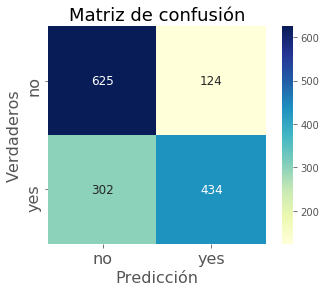

In [16]:
target_train = finalDf_train.loc[:,['target']].values
x_tr = finalDf_train.drop('target', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_tr,target_train, test_size=0.2)
lr = LogisticRegression(solver = 'lbfgs', max_iter=1000000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
grafica_scores(lr, x_test, y_test, y_pred)
lr_cm = confusion_matrix(y_test, y_pred)
grafica_matriz_confusion(lr_cm)

### Con los datos reales

Score: 0.8264104842292315
accuracy_score: 0.8264104842292315
Tasa de error: 0.17358951577076853
jaccard_similarity_score 0.8264104842292315


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.99      0.83      0.90     26263
          1       0.09      0.60      0.16       749

avg / total       0.96      0.83      0.88     27012

None




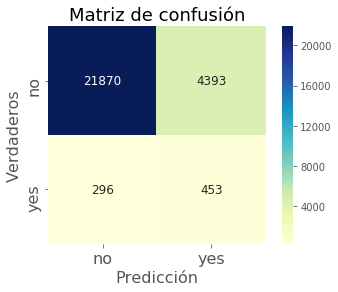

In [17]:
target_true=finalDf_test.loc[:,['target']].values
x_tr_true=finalDf_test.drop('target', axis=1)
x_train_true, x_test_true, y_train_true, y_test_true = train_test_split(x_tr_true,target_true, test_size=0.8)
y_test_pred_true=lr.predict(x_test_true)
grafica_scores(lr, x_test_true, y_test_true, y_test_pred_true)
lr_cm_true = confusion_matrix(y_test_true, y_test_pred_true)
grafica_matriz_confusion(lr_cm_true)

### Knn

Score: 0.7602693602693603
accuracy_score: 0.7602693602693603
Tasa de error: 0.23973063973063968
jaccard_similarity_score 0.7602693602693603


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.73      0.85      0.78       765
          1       0.80      0.67      0.73       720

avg / total       0.77      0.76      0.76      1485

None




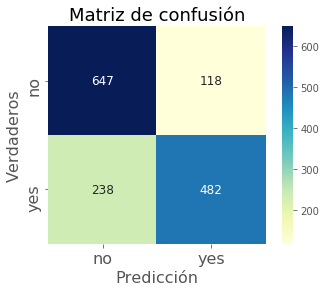

In [ ]:
target_train = finalDf_train.loc[:,['target']].values
x_tr = finalDf_train.drop('target', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_tr,target_train, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
grafica_scores(knn, x_test, y_test, y_pred)
knn_cm = confusion_matrix(y_test, y_pred)
grafica_matriz_confusion(knn_cm)

### Con los datos reales

In [ ]:
target_true=finalDf_test.loc[:,['target']].values
x_tr_true=finalDf_test.drop('target', axis=1)
x_train_true, x_test_true, y_train_true, y_test_true = train_test_split(x_tr_true,target_true, test_size=0.8)
y_test_pred_true=knn.predict(x_test_true)
grafica_scores(lr, x_test_true, y_test_true, y_test_pred_true)
knn_cm_true = confusion_matrix(y_test_true, y_test_pred_true)
grafica_matriz_confusion(knn_cm_true)